In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.special import beta
import matplotlib.pyplot as plt
from sympy import symbols, integrate
from scipy.interpolate import interp1d

<h2>Task 1</h2>

In [2]:
def lcg(n, m=2**32, a=1664525, c=1013904223, s=1):
    global lcg_seed
    seq = np.zeros(n)
    for i in range(n):
        s = (a * s + c) % m
        seq[i] = s
    return seq

In [8]:
lcg_nums = lcg(n=100)

In [6]:
def find_period_length(k, seq):
    d = {}    # Store first occurrence of each bit seq
    for i, num in enumerate(seq):
        bit_seq = num % 2**k    # Get the k lowest bits
        if bit_seq in d:
            # If the bit seq is already in the dictionary,
            # calculate the period length
            return i - d[bit_seq]
        # If the bit seq is not in the dictionary yet, we add it to it
        d[bit_seq] = i
    # If there is no sequence in the given period, we return None
    return None

In [9]:
{k: find_period_length(k, lcg_nums) for k in range(1, 4)}

{1: 2, 2: 4, 3: 8}

- The length of the period of the lowest bit: 2
- The length of the period of the two lowest bits: 4
- The length of the period of the three lowest bits: 8

<h2>Task 2</h2>

In [2]:
def p_X(x):
    n = x.shape[0]
    pdf_vals = np.zeros(n)
    for i in range(n):
        if -1 <= x[i] <= 1:
            pdf_vals[i] = (3/4) * (1 - x[i]**2)
        else:
            pdf_vals[i] = 0
    return pdf_vals

In [3]:
def visualize_pdf():
    x = np.linspace(-1, 1, 1000)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, p_X(x), zorder=2)
    ax.grid(True, alpha=0.3, zorder=1)
    ax.set_xlabel('x')
    ax.set_ylabel('p(x)')

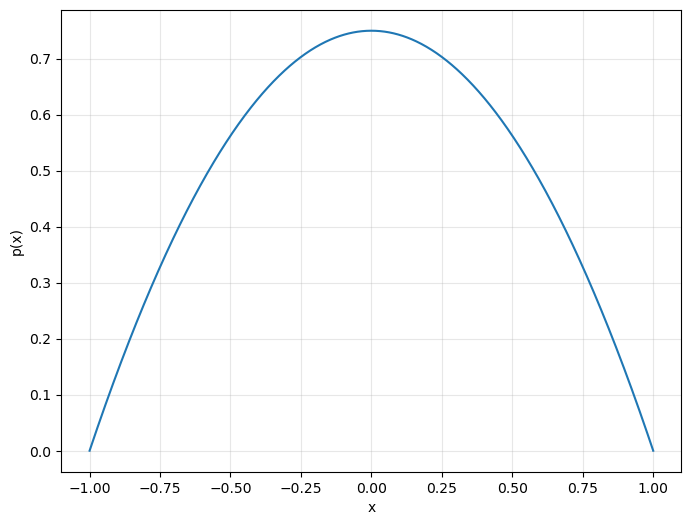

In [4]:
visualize_pdf()

In [5]:
def plot_result(samples, title=None):
    x = np.linspace(-1, 1, 1000)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, p_X(x), color='red', zorder=3)
    ax.hist(samples, density=True, bins=50, edgecolor='black', zorder=2)
    ax.grid(True, alpha=0.3, zorder=1)
    ax.set_xlabel('x')
    ax.set_ylabel('p(x)')
    if title is not None:
        ax.set_title(title)

**(a)**

In [6]:
def rejection_sampling(n):
    """
    Args:
        n: the number of samples to generate
    """
    res = np.zeros(n)
    i = 0
    while i < n:
        x = np.random.uniform(low=-1.0, high=1.0, size=1)
        y = np.random.uniform(low=0.0, high=1.0, size=1)
        if y <= p_X(x):
            res[i] = x.item()
            i += 1
    return res

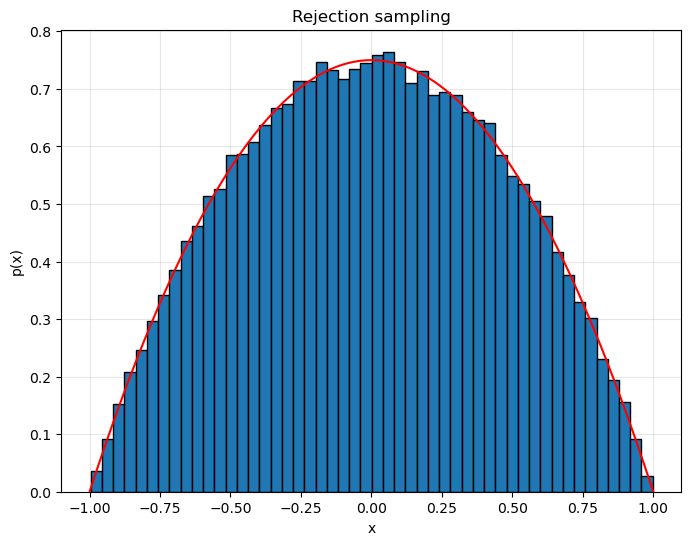

In [7]:
samples_rej = rejection_sampling(n=100000)
plot_result(samples_rej, title='Rejection sampling')

**(b)**

$$
p_{X}(x) =
\begin{cases} 
\frac{3}{4} (1 - x^2) & \text{, } -1 \le x \le 1, \\
0 & \text{, else.}
\end{cases}
$$

CDF is the ingtegral of PDF. That is,

\begin{equation*}
F(x) = P(X \le x) = \int_{-\infty}^{x} f(t) dt.
\end{equation*}

Hence,

$$
F(x) =
\begin{cases} 
\frac{-1}{4}x^3 + \frac{3}{4}x + \frac{1}{2} & \text{, } -1 \le x \le 1, \\
0 & \text{, else.}
\end{cases}
$$

For any random variable $\, X \in \mathbb{R}, \,$ the random variable $\, F_X^{-1}(U) \,$ has the same distribution as $\, X, \,$ where $\, F_X^{-1}(U) \,$ is the generalized inverse of $\, F_X \,$ and $\, U \sim \text{Uniform}(0, 1). \,$ 

We want to find some strictly monotone transformation $\, T : [0, 1] \rightarrow \mathbb{R} \,$ such that $\, T(U) \stackrel{\text{d}}{=} X \,$ (i.e., $\, T \sim F_X)$. We will have

\begin{equation*}
    F_X(x) = P(X \le x) = P(T(U) \le x) = P(U \le T^{-1}(x)) = T^{-1}(x) \, \, \, (x \in \mathbb{R}),
\end{equation*}

where the last equality follows from the fact that $\, P(U \le y) = y \,$ when $\, U \sim \text{Uniform}(0, 1). \,$ 

We can see that $\, F_X \,$ is the inverse function of $\, T \,$ (and vice versa), so we have

$$ F_{X}(u) = T^{-1}(u) \Leftrightarrow F_{X}^{-1}(u) = T(u) \, \, \, \, (u \in [0, 1]). $$

Hence, we can generate $\, X \,$ from $\, F_X^{-1}(U). \,$

In [10]:
def calculate_integral():
    t = symbols('t')
    x = symbols('x')
    f = (3/4) * (1 - t**2)
    integral = integrate(f, (t, -1, x))
    return integral

In [11]:
calculate_integral()

-0.25*x**3 + 0.75*x + 0.5

In [9]:
def F(x):
    n = x.shape[0]
    cdf_vals = np.zeros(n)
    for i in range(n):
        if -1 <= x[i] <= 1:
            cdf_vals[i] = (-1/4) * x[i]**3 + (3/4) * x[i] + (1/2)
        else:
            cdf_vals[i] = 0
    return cdf_vals

In [37]:
def inverse_random_sampling(n):
    # Evenly spaced x values for smoorth CDF
    x = np.linspace(-1, 1, 1000)
    
    # Calculate the CDF values for every x_i
    cdf_vals = F(x)
    
    # The CDF is a monotonically increasing function
    sorted_indices = np.argsort(cdf_vals)    
    cdf_vals_sorted = cdf_vals[sorted_indices]
    x_sorted = x[sorted_indices]
    
    # Numerically approximate the inverse of the CDF (quantile function)
    F_inv = interp1d(x=cdf_vals_sorted, y=x_sorted, kind='linear', fill_value='extrapolation')
    
    # Sample from U(0, 1) to generate random samples
    U = np.random.uniform(low=0, high=1, size=n)
    samples = F_inv(U)
    
    return samples

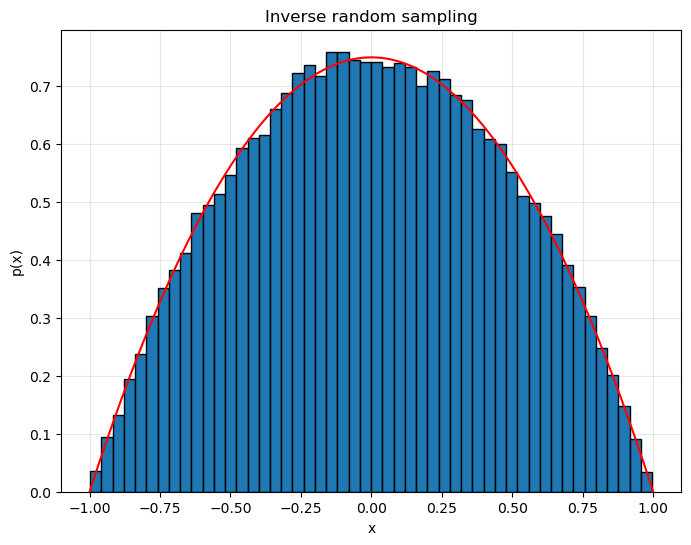

In [39]:
samples_inv = inverse_random_sampling(n=100000)
plot_result(samples_inv, title='Inverse random sampling')

<h2>Task 3</h2>

**(a)**

Since $\, X \sim \text{Beta}(\alpha, \beta), \,$ the target density function is

\begin{equation*}
    f(x) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1} (1 - x)^{\beta - 1}, \quad x \in (0, 1).
\end{equation*}

We note that $\, \large\frac{1}{B(\alpha, \beta)} \,$ is a constant and therefore it does not affect the location of the maximum because it is independent of x.

Hence, to find $\, c := \max\limits_{x \in (0,1)} f(x), \,$ we can maximize the target density with respect to x without the constant.

\begin{align*}
    f(x) &= x^{\alpha - 1} (1 - x)^{\beta - 1} \\
    \text{log} f(x) &= (\alpha - 1) \, \text{log}(x) \, + \, (\beta - 1) \, \text{log}(1 - x).
\end{align*}

\begin{equation*}
    \frac{d}{dx} \text{log} f(x) = \frac{\alpha - 1}{x} - \frac{\beta - 1}{1 - x} = 0 \quad \Leftrightarrow \quad x^* = \frac{\alpha - 1}{\alpha + \beta - 2}.
\end{equation*}

Hence

\begin{equation*}
    c := \max\limits_{x \in (0,1)} f(x) = \frac{1}{B(\alpha, \beta)} \left(\frac{\alpha - 1}{\alpha + \beta - 2} \right)^{\alpha - 1} \left(1 - \frac{\alpha - 1}{\alpha + \beta - 2} \right)^{\beta - 1}.
\end{equation*}

In [2]:
def f(x, a, b):
    """
    Notes:
        Note that including/exluding the constant (beta function) in the PDF
        does not affect the acceptance probability.
    """
    return (1 / beta(a, b)) * x**(a-1) * (1 - x)**(b - 1)

In [36]:
def g(x):
    """
    Notes:
        Since our proposal distribution is uniform, and since the density of any 
        g(x) for uniform is 1, this function is not really needed in the theoretical
        acceptance probability.
    """
    return sp.stats.uniform.pdf(x)

In [137]:
def simul_beta_distr(a, b, n):
    x_ = (a - 1) / (a + b - 2)
    c = (1 / beta(a, b)) * x_**(a-1) * (1 - x_)**(b - 1)
    
    # Simulate from [0, 1] x [0, c]
    x_samples = np.random.uniform(low=0.0, high=1.0, size=n)
    u_samples = np.random.uniform(low=0.0, high=c, size=n)
    
    # Accept the point if u <= f(x)
    accepted_samples = u_samples <= f(x_samples, a, b)
    
    # Simulated acceptance probability
    empirical_acceptance_proba = np.mean(accepted_samples)
    
    # Theoretical acceptance probability
    theoretical_acceptance_proba = np.mean(f(x_samples, a, b) / (c * g(x_samples)))
    
    print(f'Simulated acceptance probability: {empirical_acceptance_proba:.4f}')
    print(f'Theoretical acceptance probability: {theoretical_acceptance_proba:.4f}')    

In [140]:
simul_beta_distr(a=3, b=2, n=1000000)

Simulated acceptance probability: 0.5633
Theoretical acceptance probability: 0.5632


**(b)**

In [132]:
def schrodingers_cat(a, b, n):
    x_proposal = np.random.uniform(low=0.0, high=1.0, size=n)**(1/a)
    u = np.random.uniform(low=0.0, high=1.0, size=n)
    x_accepted = u <= (1 - x_proposal)**(b-1)
    acceptance_proba = np.mean(x_accepted)
    return acceptance_proba

In [135]:
schrodingers_cat(a=1, b=1, n=1000000)

np.float64(1.0)

In [136]:
schrodingers_cat(a=2, b=2, n=1000000)

np.float64(0.333066)

$\alpha = \beta = 1 \,$ gives an acceptance probability of 1.

<h2>Task 4</h2>

In [79]:
def mvnorm_sampler(u1, u2, mu, Sigma):
    """
    Converts independent U1, U2 ~ Uniform(0, 1) to independent standard normal RVs
    via the Box-Muller transformation.
    """
    R = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    z1 = R * np.cos(theta)
    z2 = R * np.sin(theta)
    
    Z = np.vstack([z1, z2])
    L = np.linalg.cholesky(Sigma)
    
    # Apply the affine transformation
    X = L[0, :][np.newaxis,:] @ Z + mu[0]   
    Y = L[1, :][np.newaxis,:] @ Z + mu[1]
    
    return X, Y

In [131]:
n = 1000000
u1 = np.random.uniform(low=0.0, high=1.0, size=n)
u2 = np.random.uniform(low=0.0, high=1.0, size=n)
mu = np.array([3., 7.])
Sigma = np.array([5, -2, -2, 11]).reshape(2,2)

In [132]:
X, Y = mvnorm_sampler(u1, u2, mu, Sigma)

In [133]:
# Mean vector
np.c_[X.T, Y.T].mean(axis=0)

array([3.00009481, 6.99919482])

In [134]:
# Covariance matrix
np.cov(np.c_[X.T, Y.T], rowvar=False)

array([[ 5.00044728, -1.99750473],
       [-1.99750473, 11.00322059]])